## Preprocessing (Original)

### Read PDF File

In [1]:
from pypdf import PdfReader

pdf_path = "../data/raw/taleoftwocities.pdf"
reader = PdfReader(pdf_path)

all_text = ""
for page in reader.pages:
    all_text += page.extract_text() + "\n"

print(all_text[:1000])

A Tale of Two Cities
Charles Dickens
Book the First
Recalled to Life
1 The Period . . . . . . . . . . . . . . . . 3
2 The Mail . . . . . . . . . . . . . . . . 5
3 The Night Shadows . . . . . . . . . . . . . 10
4 The Preparation . . . . . . . . . . . . . . 14
5 The Wine-shop . . . . . . . . . . . . . . 24
6 The Shoemaker . . . . . . . . . . . . . . 33
Book the Second
The Golden Thread
1 Five Years Later . . . . . . . . . . . . . . 45
2 A Sight . . . . . . . . . . . . . . . . . 50
3 A Disappointment . . . . . . . . . . . . . 56
4 Congratulatory . . . . . . . . . . . . . . 68
5 The Jackal . . . . . . . . . . . . . . . . 73
6 Hundreds of People . . . . . . . . . . . . . 78
7 Monseigneur in Town . . . . . . . . . . . . 89
8 Monseigneur in the Country . . . . . . . . . . 97
9 The Gorgon's Head . . . . . . . . . . . . . 102
10 Two Promises . . . . . . . . . . . . . . . 112
11 A Companion Picture . . . . . . . . . . . . 119
12 The Fellow of Delicacy . . . . . . . . . . . . 122
13 The Fellow of

### Basic Cleaning Function

In [2]:
import re

def clean_text(text: str) -> str:
    """
    - Remove excessive newlines
    - Remove repeated book title/author lines
    - Remove page numbers (lines with only digits)
    - Remove spaced-out book title lines
    - Remove 'Book the <X>' from TOC, but keep sub-book headers if immediately followed by 'Chapter 1'
    - Strip leading/trailing whitespace
    """
    # remove multiple newlines
    text = re.sub(r'\n+', '\n', text)
    
    # remove repeated title/author lines
    text = re.sub(r'^(A Tale of Two Cities|Charles Dickens)$', '', text, flags=re.MULTILINE)
    
    # remove spaced-out book title like 'A T A L E O F T W O C I T I E S'
    text = re.sub(r'^A(\s+T){1}\s+A(\s+L){1}\s+E(\s+O){1}\s+F(\s+T){1}\s+W(\s+O){1}\s+C(\s+I){1}\s+T(\s+I){1}\s+E(\s+S){1}$', '', text, flags=re.MULTILINE)
    
    # remove table of contents lines like "1 The Period . . . . 3"
    text = re.sub(r'^\d+\s+.*\.+\s*\d+', '', text, flags=re.MULTILINE)
    
    # remove lines with only numbers (page numbers)
    text = re.sub(r'^\d+\s*$', '', text, flags=re.MULTILINE)

    # remove TOC-like 'Book the X' lines if NOT immediately followed by 'Chapter 1'
    def keep_book_if_next_chapter1(match):
        start = match.end()
        remaining = match.string[start:]
        # look ahead for first non-empty line
        next_line_match = re.search(r'^\s*(.+)$', remaining, flags=re.MULTILINE)
        if next_line_match and next_line_match.group(1).startswith('Chapter 1'):
            return match.group(0)  # keep this line
        return ''  # remove TOC entry

    text = re.sub(r'^Book the (First|Second|Third)\n.*', keep_book_if_next_chapter1, text, flags=re.MULTILINE)
    
    # strip leading/trailing whitespace
    text = text.strip()
    
    return text

cleaned_text = clean_text(all_text)
print(cleaned_text[:1000])

Book the First
Recalled to Life

Chapter 1
The Period
It was the best of times, it was the worst of times, it was the age of
wisdom, it was the age of foolishness, it was the epoch of belief, it was
the epoch of incredulity, it was the season of Light, it was the season of
Darkness, it was the spring of hope, it was the winter of despair, we had
everything before us, we had nothing before us, we were all going direct
to Heaven, we were all going direct the other wayin short, the period
was so far like the present period, that some of its noisiest authorities
insisted on its being received, for good or for evil, in the superlative
degree of comparison only.
There were a king with a large jaw and a queen with a plain face, on
the throne of England; there were a king with a large jaw and a queen
with a fair face, on the throne of France. In both countries it was clearer
than crystal to the lords of the State preserves of loaves and shes, that
things in general were settled for ever.
It 

### Chunking Function

In [3]:
import re

def chunk_by_chapter_with_metadata(text: str) -> list:
    """
    Splits text into chapters and keeps metadata:
    - sub_book_number (First, Second, Third)
    - sub_book_title (e.g., 'Recalled to Life')
    - chapter_number (int)
    - chapter_title (string)
    - chapter_text
    - index
    """
    chunks = []
    sub_book_number = None
    sub_book_title = None
    chapter_pattern = re.compile(r'^Chapter (\d+)\s*(.*)')

    lines = text.split("\n")
    current_chunk = {}
    chapter_text_lines = []
    chunk_index = 0
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if not line:
            i += 1
            continue

        # detect sub-book line
        sub_book_match = re.match(r'^Book the (First|Second|Third)$', line)
        if sub_book_match:
            sub_book_number = sub_book_match.group(1)
            # next non-empty line is sub_book_title
            j = i + 1
            while j < len(lines) and not lines[j].strip():
                j += 1
            if j < len(lines):
                sub_book_title = lines[j].strip()
                i = j  # move to sub_book_title line
            i += 1
            continue

        # detect chapter start
        chapter_match = chapter_pattern.match(line)
        if chapter_match:
            # save previous chapter
            if current_chunk:
                current_chunk['chapter_text'] = "\n".join(chapter_text_lines).strip()
                current_chunk['index'] = chunk_index
                chunks.append(current_chunk)
                chunk_index += 1
                chapter_text_lines = []

            chapter_number = int(chapter_match.group(1))
            chapter_title = chapter_match.group(2).strip()

            # sometimes chapter title is missing, try to get from next line
            if not chapter_title and i+1 < len(lines):
                next_line = lines[i+1].strip()
                if next_line:
                    chapter_title = next_line
                    i += 1  # skip this line in chapter text

            current_chunk = {
                'sub_book_number': sub_book_number,
                'sub_book_title': sub_book_title,
                'chapter_number': chapter_number,
                'chapter_title': chapter_title,
                'chapter_text': ""  # placeholder
            }
        else:
            chapter_text_lines.append(line)

        i += 1

    # append last chapter
    if current_chunk:
        current_chunk['chapter_text'] = "\n".join(chapter_text_lines).strip()
        current_chunk['index'] = chunk_index
        chunks.append(current_chunk)

    return chunks

# usage
chapter_chunks = chunk_by_chapter_with_metadata(cleaned_text)
print(f"Total chapters: {len(chapter_chunks)}")
print(chapter_chunks[0])

Total chapters: 45
{'sub_book_number': 'First', 'sub_book_title': 'Recalled to Life', 'chapter_number': 1, 'chapter_title': 'The Period', 'chapter_text': "It was the best of times, it was the worst of times, it was the age of\nwisdom, it was the age of foolishness, it was the epoch of belief, it was\nthe epoch of incredulity, it was the season of Light, it was the season of\nDarkness, it was the spring of hope, it was the winter of despair, we had\neverything before us, we had nothing before us, we were all going direct\nto Heaven, we were all going direct the other way\x97in short, the period\nwas so far like the present period, that some of its noisiest authorities\ninsisted on its being received, for good or for evil, in the superlative\ndegree of comparison only.\nThere were a king with a large jaw and a queen with a plain face, on\nthe throne of England; there were a king with a large jaw and a queen\nwith a fair face, on the throne of France. In both countries it was clearer\ntha

### Save Chunks by Chapters

In [4]:
import json

def save_chunks_jsonl(chunks, output_path):
    """
    chunks: list of dicts like {
        "chapter": int,
        "chunk_id": str,
        "text": str,
        "metadata": dict
    }
    """
    with open(output_path, "w", encoding="utf-8") as f:
        for c in chunks:
            f.write(json.dumps(c, ensure_ascii=False) + "\n")


# Save the result
save_chunks_jsonl(chapter_chunks, "../data/interim/chapters.jsonl")

print(f"Saved {len(chapter_chunks)} chapters into data/interim/chapters.jsonl")

Saved 45 chapters into data/interim/chapters.jsonl


### Load Json for Embedding

In [5]:
def load_chunks_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            yield json.loads(line)

## EDA Original

### Chapter Level Stats

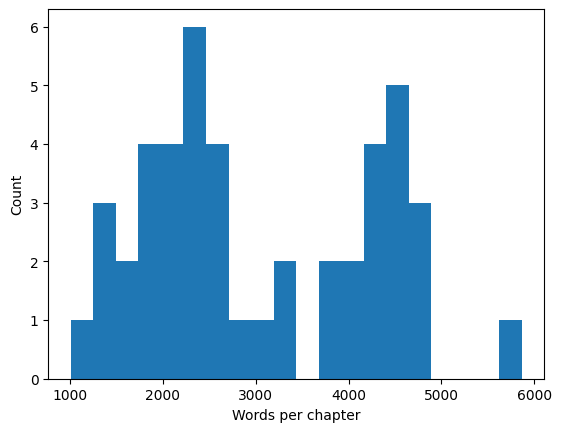

In [6]:
import matplotlib.pyplot as plt

chapter_lengths = [len(c['chapter_text'].split()) for c in chapter_chunks]
plt.hist(chapter_lengths, bins=20)
plt.xlabel('Words per chapter')
plt.ylabel('Count')
plt.show()

### Sub-book Stats

Recalled to Life: 6 chapters, avg words per chapter: 2897.7
The Golden Thread: 24 chapters, avg words per chapter: 2940.8
The Track of a Storm: 15 chapters, avg words per chapter: 3229.9


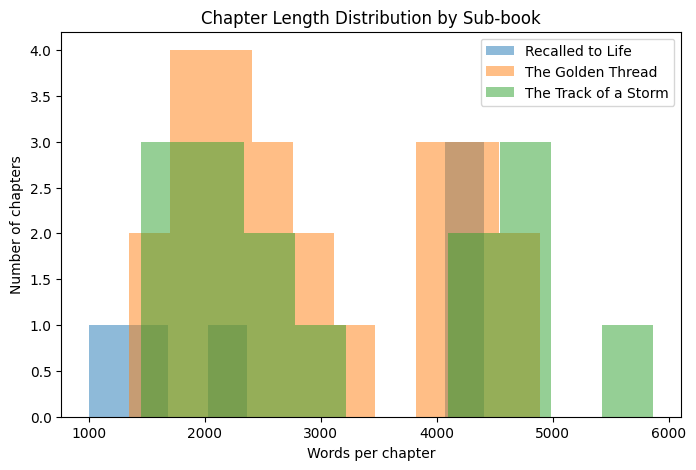

In [7]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Group chapters by sub-book
sub_book_stats = defaultdict(list)

for c in chapter_chunks:
    sub_book = c['sub_book_title']  # or use c['sub_book_number'] if you prefer
    chapter_len = len(c['chapter_text'].split())  # word count
    sub_book_stats[sub_book].append(chapter_len)

# Print average chapter length per sub-book
for sub_book, lengths in sub_book_stats.items():
    avg_len = sum(lengths) / len(lengths)
    print(f"{sub_book}: {len(lengths)} chapters, avg words per chapter: {avg_len:.1f}")

# Plot distribution
plt.figure(figsize=(8,5))
for sub_book, lengths in sub_book_stats.items():
    plt.hist(lengths, bins=10, alpha=0.5, label=sub_book)
plt.xlabel('Words per chapter')
plt.ylabel('Number of chapters')
plt.title('Chapter Length Distribution by Sub-book')
plt.legend()
plt.show()


### Vobaulary (Token Level) Analysis

In [8]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

all_words = ' '.join(c['chapter_text'] for c in chapter_chunks).split()
word_counts = Counter([w.lower() for w in all_words if w.lower() not in ENGLISH_STOP_WORDS])
word_counts.most_common(20)

[('mr.', 602),
 ('said', 570),
 ('\x93i', 410),
 ('little', 253),
 ('it,', 228),
 ('him,', 226),
 ('man', 211),
 ('miss', 202),
 ('looked', 186),
 ('like', 184),
 ('know', 175),
 ('good', 159),
 ('long', 159),
 ('great', 159),
 ('lorry', 158),
 ('old', 156),
 ('but,', 153),
 ('time', 146),
 ('it.', 144),
 ('\x93you', 141)]

### Topic/Keyword Analysis

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform([c['chapter_text'] for c in chapter_chunks])
feature_names = vectorizer.get_feature_names_out()
# Inspect TF-IDF scores for chapter 0
import numpy as np
top_indices = np.argsort(X[0].toarray()[0])[::-1][:10]
print([feature_names[i] for i in top_indices])


['farmer', 'musketeers', 'woodman', 'shot', 'period', 'seventy', 'seven', 'cock', 'mall', 'spiritual']


### Topic/Keyword Analysis Per Sub-Book

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Prepare documents
docs = [c['chapter_text'] for c in chapter_chunks]
chapter_ids = [f"{c['sub_book_title']} - Chapter {c['chapter_number']}" for c in chapter_chunks]

# TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(docs)
tfidf_df = pd.DataFrame(X.toarray(), index=chapter_ids, columns=vectorizer.get_feature_names_out())

# Top 10 words per chapter
for idx, row in tfidf_df.iterrows():
    top_words = row.sort_values(ascending=False).head(10)
    print(f"{idx}: {', '.join(top_words.index)}")


Recalled to Life - Chapter 1: farmer, seven, thousand, year, ve, queen, london, england, tradesman, france
Recalled to Life - Chapter 2: guard, mail, coach, passenger, passengers, horse, dover, jerry, hill, mist
Recalled to Life - Chapter 3: passenger, dig, coach, buried, shadows, message, bank, real, night, mail
Recalled to Life - Chapter 4: sir, lorry, mr, business, gentleman, miss, tellson, manette, wig, breakfast
Recalled to Life - Chapter 5: wine, defarge, shop, monsieur, hunger, madame, door, keeper, jacques, little
Recalled to Life - Chapter 6: weep, shoe, monsieur, defarge, shoemaker, hand, lorry, mr, work, long
The Golden Thread - Chapter 1: cruncher, tellson, jerry, mr, mother, temple, bar, son, death, fleet
The Golden Thread - Chapter 2: jerry, bailey, mr, court, judge, sir, prisoner, said, cruncher, law
The Golden Thread - Chapter 3: prisoner, mr, attorney, jury, board, witness, lists, general, lorry, ies
The Golden Thread - Chapter 4: mr, darnay, carton, lorry, business, d

### Chunk Consistency

In [11]:
# Set thresholds
min_words = 1000
max_words = 6000

for c in chapter_chunks:
    num_words = len(c['chapter_text'].split())
    if num_words < min_words:
        print(f"Chapter {c['chapter_number']} ({c['sub_book_title']}) is too short: {num_words} words")
    elif num_words > max_words:
        print(f"Chapter {c['chapter_number']} ({c['sub_book_title']}) is too long: {num_words} words")
    elif num_words == 0:
        print(f"Chapter {c['chapter_number']} ({c['sub_book_title']}) is empty")

### Keyword Visualization And Frequency Analysis Per Sub-Book

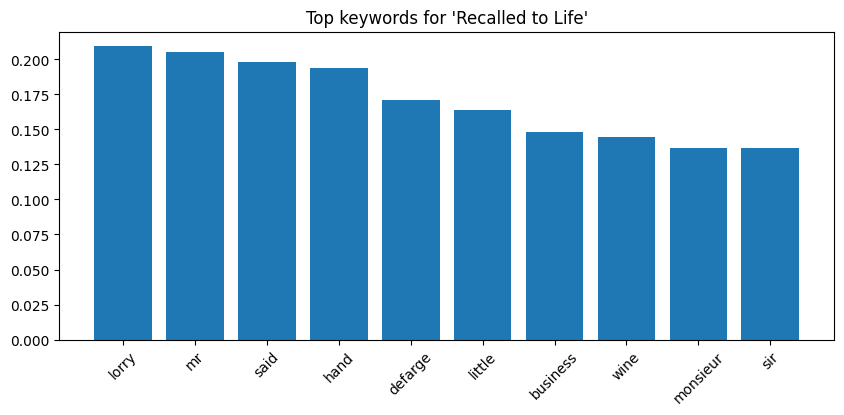

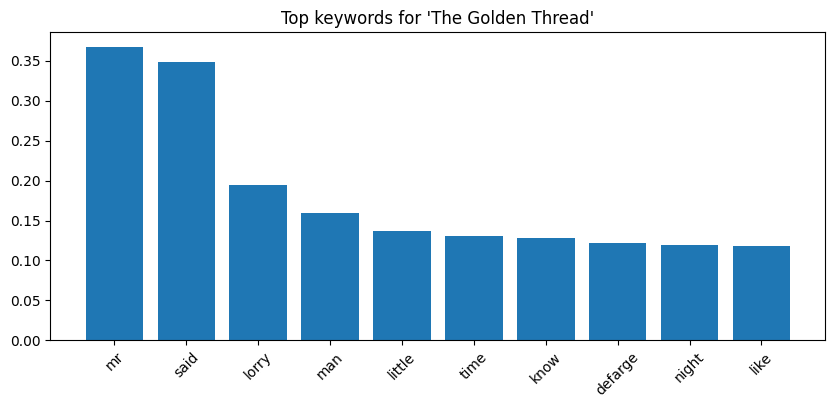

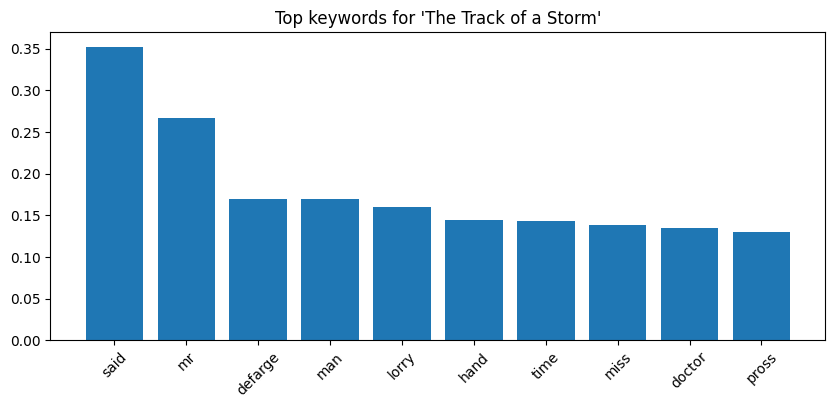

Overall most common words: [('the', 7338), ('and', 4681), ('of', 3942), ('to', 3385), ('a', 2767), ('in', 2388), ('his', 1914), ('was', 1674), ('that', 1654), ('I', 1451), ('he', 1386), ('had', 1263), ('with', 1243), ('it', 1165), ('as', 1007), ('at', 960), ('you', 855), ('for', 848), ('her', 819), ('on', 810)]


In [12]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Assume chapter_chunks is your list of dicts with metadata:
# 'sub_book_title', 'chapter_text'

# Aggregate text per sub-book
sub_book_texts = {}
for chunk in chapter_chunks:
    title = chunk['sub_book_title']
    text = chunk['chapter_text']
    sub_book_texts.setdefault(title, []).append(text)

for title in sub_book_texts:
    sub_book_texts[title] = " ".join(sub_book_texts[title])

# Count most common words per sub-book
def get_top_keywords(text, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform([text])
    words = vectorizer.get_feature_names_out()
    scores = X.toarray().flatten()
    word_score = dict(zip(words, scores))
    sorted_words = sorted(word_score.items(), key=lambda x: x[1], reverse=True)
    return sorted_words[:top_n]

# Visualize top keywords per sub-book
for title, text in sub_book_texts.items():
    top_words = get_top_keywords(text, top_n=10)
    words, scores = zip(*top_words)
    plt.figure(figsize=(10,4))
    plt.bar(words, scores)
    plt.title(f"Top keywords for '{title}'")
    plt.xticks(rotation=45)
    plt.show()

# Overall most common words
all_text = " ".join([chunk['chapter_text'] for chunk in chapter_chunks])
counter = Counter(all_text.split())
print("Overall most common words:", counter.most_common(20))


## Preprocessing (Refined)

### Remove Stop Words from Chunks

In [13]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords_from_chapter_text(chunks: list) -> list:
    """
    Takes list of chapter dicts and removes stop words only from chapter_text.
    """
    for chunk in chunks:
        text = chunk['chapter_text']
        # remove stop words
        words = [w for w in text.split() if w.lower() not in stop_words]
        chunk['chapter_text'] = " ".join(words)
    return chunks

# usage:
chapter_chunks = chunk_by_chapter_with_metadata(cleaned_text)  # unchanged
chapter_chunks = remove_stopwords_from_chapter_text(chapter_chunks)

### Save Chunks

In [14]:
# Save the result
save_chunks_jsonl(chapter_chunks, "../data/preprocessed/chapters.jsonl")

print(f"Saved {len(chapter_chunks)} chapters into data/preprocessed/chapters.jsonl")

Saved 45 chapters into data/preprocessed/chapters.jsonl
